In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from scipy.io import wavfile
from scipy import signal

In [10]:
# Path to data set
data_dir = pathlib.Path('data/classification')

In [11]:
# Training Classes
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['clapping' 'footfall']


In [12]:
# Shuffle filenames of the training classes
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])
filenames[0]

Number of total examples: 400
Number of examples per label: 200
Example file tensor: tf.Tensor(b'data\\classification\\clapping\\1_1-115920-A-22.wav', shape=(), dtype=string)


<tf.Tensor: shape=(), dtype=string, numpy=b'data\\classification\\clapping\\1_1-115920-A-22.wav'>

In [13]:
# Split the dataset into training, validation and testing datasets in the ratio 8:2:2 respectively
train_files = filenames[:160]
val_files = filenames[160: 180]
test_files = filenames[-20:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 160
Validation set size 20
Test set size 20


In [14]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [15]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [17]:
v = get_waveform_and_label(train_files[0])

In [18]:
v

(<tf.Tensor: shape=(44100,), dtype=float32, numpy=
 array([0.00186157, 0.00183105, 0.00180054, ..., 0.01589966, 0.01593018,
        0.01629639], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'clapping'>)

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
print(AUTOTUNE)

-1


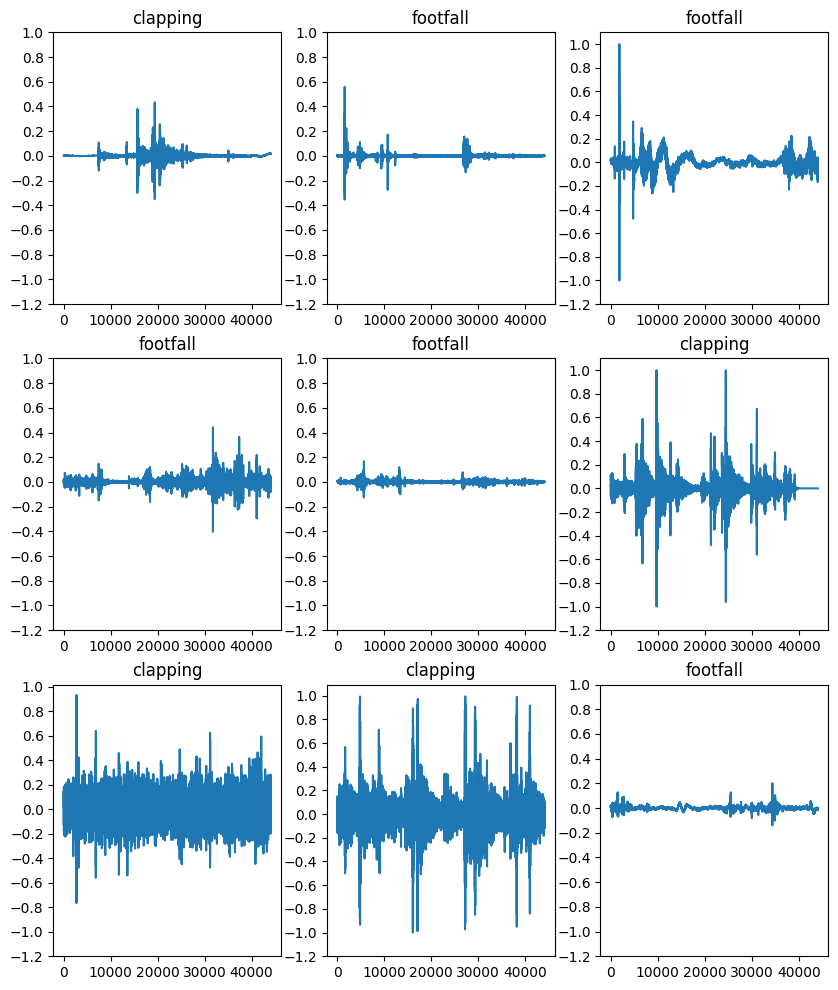

In [20]:
# Visualise the a sample of training dataset in the time domain
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [14]:
def stft(x):
    f, t, spec = signal.stft(x.numpy(), fs=44100, nperseg=512, noverlap = 256, nfft=512)
    return tf.convert_to_tensor(np.abs(spec))

def get_spectrogram(waveform):
    
  spectrogram = tf.py_function(func=stft, inp=[waveform], Tout=tf.float32)
       
  spectrogram.set_shape((257,174))

  #spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
      
  #spectrogram = tf.abs(spectrogram)
  print("spectrogram:", spectrogram)

  return spectrogram

In [15]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

spectrogram: tf.Tensor(
[[9.0231153e-04 6.9428713e-04 6.1797211e-04 ... 6.8612385e-04
  2.9463592e-04 5.5776309e-06]
 [8.4210560e-04 8.1149786e-04 1.0757095e-03 ... 3.1427841e-04
  3.5098175e-04 5.5356991e-06]
 [6.9029274e-04 4.0031387e-04 1.1197575e-03 ... 5.7376589e-04
  2.5998041e-04 5.4117609e-06]
 ...
 [2.1998230e-06 6.6259793e-07 1.6411359e-07 ... 4.1605134e-07
  2.1062019e-06 3.4718173e-07]
 [1.9943063e-06 5.0657582e-07 2.4744918e-07 ... 3.7536083e-07
  1.7641792e-06 3.4555265e-07]
 [1.9619813e-06 1.5408142e-08 2.6360041e-07 ... 4.6074931e-07
  1.1892965e-06 3.4496213e-07]], shape=(257, 174), dtype=float32)
spectrogram: tf.Tensor(
[[4.1984483e-03 1.8703682e-02 1.2502160e-02 ... 2.5398030e-03
  5.2068807e-04 2.9667586e-05]
 [3.4473583e-03 1.0385575e-02 7.5281952e-03 ... 4.9662252e-04
  1.0279466e-03 2.8915731e-05]
 [1.8399728e-03 1.1337112e-03 2.6532332e-03 ... 2.0415734e-03
  7.1501650e-04 2.6803242e-05]
 ...
 [6.9470566e-06 4.4712414e-07 5.2006021e-07 ... 2.1627591e-07
  2.1917

(174,) range(0, 257) (257, 174)


C:\Users\User\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


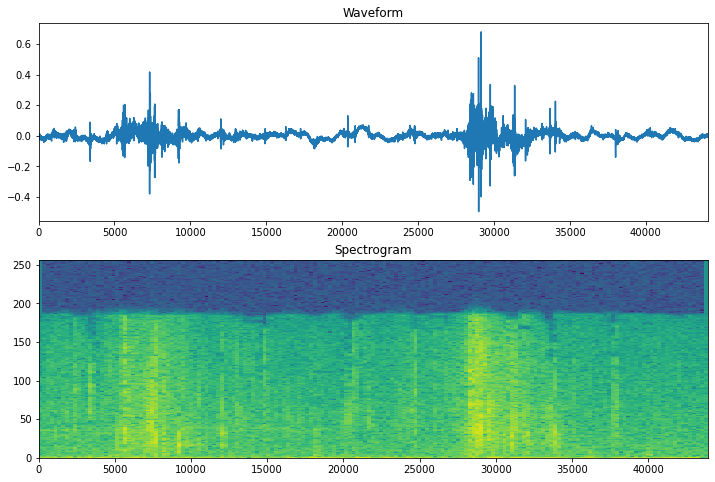

In [16]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram)
    height = log_spec.shape[0]
    X = np.arange(44100, step=height-3)
    Y = range(height)
    print(X.shape, Y, log_spec.shape)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 44100])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(tf.cast(label == commands, "uint32"))
  return spectrogram, label_id

In [18]:
print(type(waveform_ds))
print(type(label), type(commands))
print(commands)
a = tf.constant((label == commands), "uint8")
label_id = tf.argmax(a)
print(label_id)

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<class 'str'> <class 'numpy.ndarray'>
['clapping' 'footfall']
tf.Tensor(1, shape=(), dtype=int64)


In [19]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

spectrogram: Tensor("EagerPyFunc:0", shape=(257, 174), dtype=float32, device=/job:localhost/replica:0/task:0)


(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)
(174,) range(0, 257) (257, 174)


C:\Users\User\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


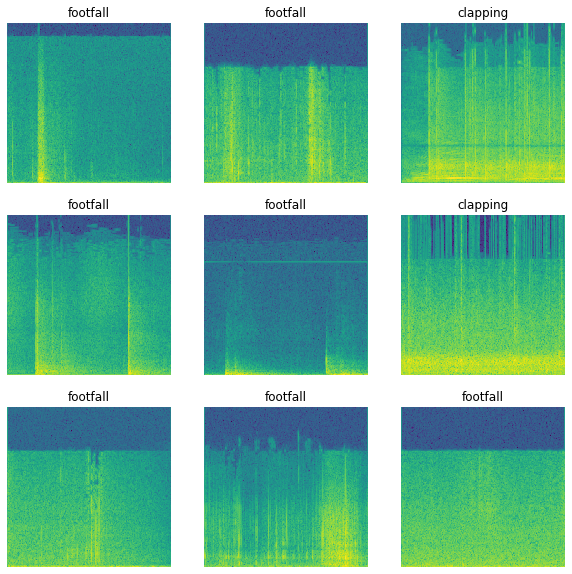

In [20]:
# Visualise the training wavfiles in the frequency domain
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

spectrogram: Tensor("EagerPyFunc:0", shape=(257, 174), dtype=float32, device=/job:localhost/replica:0/task:0)
spectrogram: Tensor("EagerPyFunc:0", shape=(257, 174), dtype=float32, device=/job:localhost/replica:0/task:0)


In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Set the model parameters
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (257, 174, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
3/3 [==============================] - 5s 464ms/step - loss: 0.6066 - accuracy: 0.6062 - val_loss: 0.5255 - val_accuracy: 0.8000
Epoch 2/10
3/3 [==============================] - 0s 158ms/step - loss: 0.4324 - accuracy: 0.8125 - val_loss: 0.4916 - val_accuracy: 0.8000
Epoch 3/10
3/3 [==============================] - 0s 151ms/step - loss: 0.4179 - accuracy: 0.8125 - val_loss: 0.4740 - val_accuracy: 0.8500
Epoch 4/10
3/3 [==============================] - 0s 154ms/step - loss: 0.3890 - accuracy: 0.8438 - val_loss: 0.4782 - val_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 0s 152ms/step - loss: 0.3768 - accuracy: 0.8313 - val_loss: 0.4662 - val_accuracy: 0.8000
Epoch 6/10
3/3 [==============================] - 0s 154ms/step - loss: 0.3343 - accuracy: 0.8625 - val_loss: 0.4409 - val_accuracy: 0.8500
Epoch 7/10
3/3 [==============================] - 0s 150ms/step - loss: 0.3186 - accuracy: 0.8750 - val_loss: 0.4204 - val_accuracy: 0.8500
Epoch 8/10
3/3 [====

In [28]:
model.save('acoustic_classification_model.sav')

INFO:tensorflow:Assets written to: simple_audio_model_numpy.sav\assets


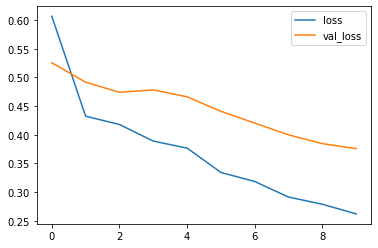

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 85%


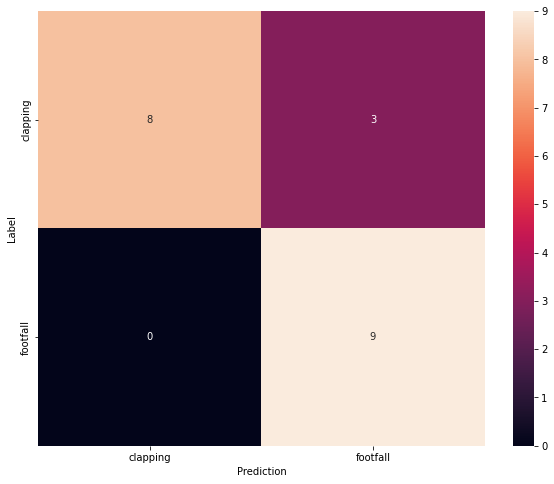

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

spectrogram: Tensor("EagerPyFunc:0", shape=(257, 174), dtype=float32, device=/job:localhost/replica:0/task:0)


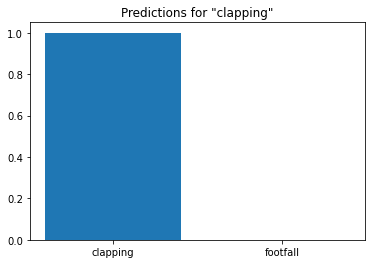

In [33]:
sample_file = data_dir/'clapping/1_3-177082-A-22.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [34]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('acoustic_classification_model.sav') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('acoustic_classification.tflite', 'wb') as f:
  f.write(tflite_model)